# Neural Network Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil

from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform

%matplotlib inline

In [2]:
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [3]:
train['played'] = 1
test['played'] = 1

In [6]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0])
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0])
neg_samples = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})

In [8]:
train = train.merge(neg_samples, how="outer", on=['user_id', 'game_id'])

In [10]:
train.played = np.where(train.played != 1, 0, 1)

## Neural Network Construction

In [12]:
# game input and embedding
game_input = keras.layers.Input(shape=[1], name='Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, 20,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='FlattenGames')(game_embedding)

In [13]:
# user input and embedding
user_input = keras.layers.Input(shape=[1], name='User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, 20,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [14]:
concat = keras.layers.concatenate([game_vec, user_vec])
 
mlp = concat
for i in range(3,-1,-1):
    if i == 0:
      mlp = Dense(8**i, activation='sigmoid', kernel_initializer='glorot_normal',
                  name="output")(mlp)
    else:
      mlp = Dense(8*2**i, activation='relu', kernel_initializer='he_uniform')(mlp)
      if i > 2:
        mlp = BatchNormalization()(mlp)
        mlp = Dropout(0.2)(mlp)
 
model = Model(inputs=[user_input, game_input], outputs=[mlp])
 
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game-Embedding (Embedding)      (None, 1, 20)        31600       Game[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        42520       User[0][0]                       
______________________________________________________________________________________________

## Model Training

In [16]:
history = model.fit([train.user_id, train.game_id], train.played, epochs=100)

Train on 41884 samples
Epoch 1/100
41884/41884 [==============================] - 5s 123us/sample - loss: 0.4403 - binary_accuracy: 0.9676
Epoch 2/100
41884/41884 [==============================] - 4s 101us/sample - loss: 0.4069 - binary_accuracy: 0.9819
Epoch 3/100
41884/41884 [==============================] - 4s 103us/sample - loss: 0.3702 - binary_accuracy: 0.9907
Epoch 4/100
41884/41884 [==============================] - 4s 100us/sample - loss: 0.3322 - binary_accuracy: 0.9959
Epoch 5/100
41884/41884 [==============================] - 4s 100us/sample - loss: 0.2957 - binary_accuracy: 0.9988
Epoch 6/100
41884/41884 [==============================] - 4s 101us/sample - loss: 0.2592 - binary_accuracy: 0.9993
Epoch 7/100
41884/41884 [==============================] - 4s 105us/sample - loss: 0.2254 - binary_accuracy: 0.9999
Epoch 8/100
41884/41884 [==============================] - 4s 102us/sample - loss: 0.1945 - binary_accuracy: 1.0000
Epoch 9/100
41884/41884 [========================

Text(0, 0.5, 'Training Error')

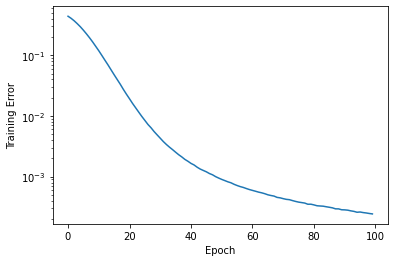

In [18]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [21]:
results = model.evaluate((test.user_id, test.game_id), test.played, batch_size=1)

7546/7546 [==============================] - 11s 2ms/sample - loss: 2.3351e-04 - binary_accuracy: 1.0000


In [24]:
game_embedding_learnt = model.get_layer(name='Game-Embedding').get_weights()[0]
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]

In [ ]:
def recommend(user_id, number_of_games=5):
  movies = user_embedding_learnt[user_id]@game_embedding_learnt.T
  mids = np.argpartition(game_embedding, -number_of_movies)[-number_of_movies:]
  return mids